In [ ]:
# import pandas as pd
# import numpy as np
# from ahrs.filters import Mahony
# from ahrs.common.orientation import q2euler

# # --- USER CONFIGURATION ---
# input_csv = '/Users/benjaminli/Downloads/S_82924/PANORAMIC_RIGHT_all_sensors.csv'         # path to your CSV file
# start_time = '2024-05-17 14:05:49'  # replace with your start time
# end_time   = '2024-05-17 14:05:56'  # replace with your end time

# # Load and clean the CSV
# df = pd.read_csv(input_csv)
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# # Drop rows with missing gyro or accel
# df = df.dropna(subset=['GYRO_x', 'GYRO_y', 'GYRO_z', 'HE_ACC_x', 'HE_ACC_y', 'HE_ACC_z'])

# # Filter between desired times
# mask = (df['timestamp'] >= pd.to_datetime(start_time)) & (df['timestamp'] <= pd.to_datetime(end_time))
# df_filtered = df.loc[mask].reset_index(drop=True)

# # Initialize Mahony filter
# mahony = Mahony(Kp=1.0, Ki=0.0, sampleperiod=0.01)
# q = np.array([1.0, 0.0, 0.0, 0.0])  # Initial quaternion

# # For storing results
# quaternions = []
# eulers = []
# timestamps = []

# prev_time = None

# for i, row in df_filtered.iterrows():
#     if prev_time is None:
#         prev_time = row['timestamp']
#         continue

#     # Time delta
#     dt = (row['timestamp'] - prev_time).total_seconds()
#     prev_time = row['timestamp']
#     mahony.sampleperiod = dt

#     # Sensor readings
#     gyro = np.array([row['GYRO_x'], row['GYRO_y'], row['GYRO_z']]) * np.pi / 180  # deg/s → rad/s
#     accel = np.array([row['HE_ACC_x'], row['HE_ACC_y'], row['HE_ACC_z']])

#     # Update filter
#     q = mahony.updateIMU(q, gyr=gyro, acc=accel)
#     if q is None:
#         continue

#     # Store results
#     quaternions.append(q)
#     eulers.append(q2euler(q))  # radians
#     timestamps.append(row['timestamp'])

# # Convert results to DataFrame
# results = pd.DataFrame({
#     'timestamp': timestamps,
#     'qw': [q[0] for q in quaternions],
#     'qx': [q[1] for q in quaternions],
#     'qy': [q[2] for q in quaternions],
#     'qz': [q[3] for q in quaternions],
#     'roll': [e[0] for e in eulers],
#     'pitch': [e[1] for e in eulers],
#     'yaw': [e[2] for e in eulers],
# })

# # Save or return
# results.to_csv('fused_segment.csv', index=False)
# print("Fused segment saved to 'fused_segment.csv'")


Fused segment saved to 'fused_segment.csv'


In [11]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # --- UTILITY FUNCTIONS ---
# def quaternion_conjugate(q):
#     return np.array([q[0], -q[1], -q[2], -q[3]])

# def quaternion_multiply(q1, q2):
#     w1, x1, y1, z1 = q1
#     w2, x2, y2, z2 = q2
#     return np.array([
#         w1*w2 - x1*x2 - y1*y2 - z1*z2,
#         w1*x2 + x1*w2 + y1*z2 - z1*y2,
#         w1*y2 - x1*z2 + y1*w2 + z1*x2,
#         w1*z2 + x1*y2 - y1*x2 + z1*w2
#     ])

# def quaternion_rotate(q, v):
#     """Rotate a 3-vector v by quaternion q."""
#     qv = np.concatenate([[0.], v])
#     return quaternion_multiply(
#         quaternion_multiply(q, qv),
#         quaternion_conjugate(q)
#     )[1:]

# # --- FILES & CONFIG ---
# RAW_CSV   = '/Users/benjaminli/Downloads/S_82924/PANORAMIC_RIGHT_all_sensors.csv'      # original CSV with accel/gyro
# FUSED_CSV = '/Users/benjaminli/Code/Industrial_Project/fused_segment.csv'  # output from fusion step

# # High-pass filter cutoff (Hz)
# fc  = 0.1    # try 0.1–0.5 Hz to remove very slow drift
# # ----------------------------

# # Compute filter constant τ and alpha
# #   τ = 1 / (2πfc)
# #   α = τ / (τ + dt)
# # We'll recompute α each loop since dt can vary.
# tau = 1.0 / (2.0 * np.pi * fc)

# # 1) Load raw sensor data
# df_raw = pd.read_csv(RAW_CSV)
# df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
# df_sensor = df_raw.dropna(subset=['GYRO_x','GYRO_y','GYRO_z',
#                                    'HE_ACC_x','HE_ACC_y','HE_ACC_z'])

# # 2) Load fused orientations
# df_fused = pd.read_csv(FUSED_CSV)
# df_fused['timestamp'] = pd.to_datetime(df_fused['timestamp'])

# # 3) Merge on timestamp
# df = pd.merge(df_sensor, df_fused, on='timestamp', how='inner') \
#        .sort_values('timestamp') \
#        .reset_index(drop=True)

# N = len(df)
# acc_lin = np.zeros((N, 3))
# acc_hp  = np.zeros((N, 3))  # high-pass filtered accel
# vel     = np.zeros((N, 3))
# pos     = np.zeros((N, 3))

# # 4) Gravity compensation + HPF + integration
# for i in range(1, N):
#     # a) compute dt
#     dt = (df.loc[i, 'timestamp'] - df.loc[i-1, 'timestamp']).total_seconds()
#     α  = tau / (tau + dt)

#     # b) rotate gravity into sensor frame and subtract
#     q       = df.loc[i, ['qw','qx','qy','qz']].values
#     acc_raw = df.loc[i, ['HE_ACC_x','HE_ACC_y','HE_ACC_z']].values
#     g_s     = quaternion_rotate(q, np.array([0., 0., 9.81]))
#     a_lin   = acc_raw - g_s
#     acc_lin[i] = a_lin

#     # c) apply first-order high-pass filter:
#     #    y[i] = α * ( y[i-1] + x[i] - x[i-1] )
#     acc_hp[i] = α * (acc_hp[i-1] + acc_lin[i] - acc_lin[i-1])

#     # d) integrate HPF accel → velocity
#     vel[i] = vel[i-1] + 0.5 * (acc_hp[i] + acc_hp[i-1]) * dt

#     # e) integrate velocity → position
#     pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt

# # 5) Plot trajectory
# fig = plt.figure()
# ax  = fig.add_subplot(111, projection='3d')
# ax.plot(pos[:,0], pos[:,1], pos[:,2], label='Trajectory')
# ax.set_xlabel('X Position (m)')
# ax.set_ylabel('Y Position (m)')
# ax.set_zlabel('Z Position (m)')
# ax.legend()
# plt.tight_layout()
# plt.show()


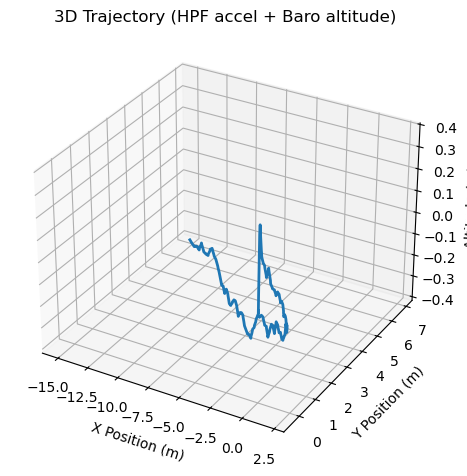

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ahrs.filters import Mahony

# --- UTILITY FUNCTIONS ---
def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_rotate(q, v):
    """Rotate a 3-vector v by quaternion q (w, x, y, z)."""
    qv = np.concatenate([[0.0], v])
    return quaternion_multiply(
        quaternion_multiply(q, qv),
        quaternion_conjugate(q)
    )[1:]

def pressure_to_altitude(p, p0):
    """
    Barometric formula: returns altitude above reference p0.
    p, p0 in same units (e.g. Pa).
    """
    return 44330.0 * (1.0 - (p / p0)**(1/5.255))

# --- USER CONFIGURATION ---
csv_path = '/Users/benjaminli/Downloads/S_82924/PANORAMIC_RIGHT_all_sensors.csv'         # path to your CSV file
start_time = '2024-05-17 14:05:49'  # replace with your start time
end_time   = '2024-05-17 14:05:56'  # replace with your end time

# High-pass filter cutoff to suppress accel drift (Hz)
fc  = 0.1
# Mahony gains
Kp = 1.0
Ki = 0.0
# ----------------------------

# Precompute filter constant
tau = 1.0 / (2.0 * np.pi * fc)

# 1) Load & time-filter the CSV
df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Ensure timestamps are sorted
df = df.sort_values('timestamp').reset_index(drop=True)

# Interpolate numeric columns linearly (excluding timestamp)
df_interp = df.interpolate(method='linear', limit_direction='both')

# Drop any remaining NaNs if interpolation failed at start/end
df = df_interp.dropna(subset=[
    'GYRO_x','GYRO_y','GYRO_z',
    'HE_ACC_x','HE_ACC_y','HE_ACC_z',
    'MAGNETIC_FIELD_x','MAGNETIC_FIELD_y','MAGNETIC_FIELD_z',
    'PRESSURE'
]).reset_index(drop=True)


mask = (
    (df['timestamp'] >= pd.to_datetime(start_time)) &
    (df['timestamp'] <= pd.to_datetime(end_time))
)
df = df.loc[mask].reset_index(drop=True)
N = len(df)
if N < 2:
    raise ValueError("Not enough data in the specified time window.")

# 2) Prepare storage
# Orientation
q = np.array([1.0, 0.0, 0.0, 0.0])
mahony = Mahony(Kp=Kp, Ki=Ki, sampleperiod=0.01)

# Data arrays
acc_lin = np.zeros((N, 3))  # gravity-removed accel
acc_hp  = np.zeros((N, 3))  # high-pass filtered accel
vel     = np.zeros((N, 3))
pos     = np.zeros((N, 3))
alt     = np.zeros(N)

# Reference pressure for altitude (first sample)
p0 = df.loc[0, 'PRESSURE']

prev_t         = df.loc[0, 'timestamp']
prev_acc_lin   = np.zeros(3)
acc_hp[0]      = np.zeros(3)
vel[0]         = np.zeros(3)
pos[0]         = np.zeros(3)
alt[0]         = pressure_to_altitude(df.loc[0, 'PRESSURE'], p0)

# 3) Main processing loop
for i, row in df.iterrows():
    if i == 0:
        continue

    # time step
    t0 = prev_t
    t1 = row['timestamp']
    dt = (t1 - t0).total_seconds()
    if dt <= 0:
        continue
    prev_t = t1

    # update Mahony sample period
    mahony.sampleperiod = dt

    # read sensors
    gyro  = np.array([row['GYRO_x'], row['GYRO_y'], row['GYRO_z']]) * np.pi/180.0
    accel = np.array([row['HE_ACC_x'], row['HE_ACC_y'], row['HE_ACC_z']])
    mag   = np.array([
        row['MAGNETIC_FIELD_x'],
        row['MAGNETIC_FIELD_y'],
        row['MAGNETIC_FIELD_z']
    ])
    p     = row['PRESSURE']

    # 3-axis gyro + accel + mag → orientation quaternion
    # Use the 9-axis update (MARG) for better yaw
    q = mahony.updateMARG(q, gyr=gyro, acc=accel, mag=mag)

    # gravity compensation
    g_s      = quaternion_rotate(q, np.array([0.0, 0.0, 9.81]))
    a_lin    = accel - g_s
    acc_lin[i] = a_lin

    # high-pass filter on linear accel
    alpha = tau / (tau + dt)
    acc_hp[i] = alpha * (acc_hp[i-1] + a_lin - prev_acc_lin)
    prev_acc_lin = a_lin

    # integrate accel → velocity
    vel[i] = vel[i-1] + 0.5 * (acc_hp[i] + acc_hp[i-1]) * dt
    # integrate velocity → horizontal position
    pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt

    # pressure → altitude
    alt[i] = pressure_to_altitude(p, p0)

# 4) Plot the 3D trajectory
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0], pos[:,1], alt, lw=2)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Altitude (m)')
ax.set_title('3D Trajectory (HPF accel + Baro altitude)')
plt.tight_layout()
plt.show()
